# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [78]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from bs4 import BeautifulSoup

import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,TfidfTransformer
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score,auc,roc_curve,classification_report,precision_score,recall_score,f1_score, hamming_loss

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from prettytable import PrettyTable

from sklearn.svm import SVC

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('D:\Study_materials\Applied_AI\Assignments\database.sqlite') 

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", con)

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)

Number of data points in our data (525814, 10)


In [3]:
sample_data = filtered_data.head(100000)

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [4]:
#Sorting data according to ProductId in ascending order
sorted_data=sample_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [5]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [6]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(sample_data['Id'].size*1.0)*100

87.775

In [7]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [8]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

In [9]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...
70677,76870,B00002N8SM,A19Q006CSFT011,Arlielle,0,0,0,1288396800,only one fruitfly stuck,"I had an infestation of fruitflies, they were ..."
70676,76869,B00002N8SM,A1FYH4S02BW7FN,wonderer,0,0,0,1290038400,Doesn't work!! Don't waste your money!!,Worst product I have gotten in long time. Woul...
70675,76868,B00002N8SM,AUE8TB5VHS6ZV,eyeofthestorm,0,0,0,1306972800,A big rip off,I wish I'd read the reviews before making this...


#  [3] Preprocessing

In [10]:
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

4
I wish I'd read the reviews before making this purchase. It's basically a cardsotck box that is sticky all over the OUTSIDE. Those pink-ish things that look like entrances "into" the trap? They're just pictures. There *is no* inside of the trap. All the flies will be stuck to the OUTSIDE. It's basically fly paper, just horribly, horribly HORRIBLY overpriced.<br /><br />Do yourself a favor and just get fly paper or fly strips. Same yuck factor, but much cheaper.


In [11]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'during', 'when', 'they', 'no', "didn't", 'than', 'such', 'mightn', 'there', 'up', 'under', 'on', 'those', "hadn't", 'how', 'ourselves', 'ain', 'in', 'about', 'down', 'very', 'she', 'be', 'wouldn', 'our', 'm', 'themselves', 'a', 'other', 'should', 'were', 'having', 'of', 'while', "you've", 'only', 'theirs', 'it', 'some', 'just', "should've", 'aren', "mustn't", "needn't", 'what', "you're", 'is', 'can', 'shan', 'weren', 'them', 'at', 'both', 'or', 'my', 'him', 'his', 'from', 'below', "mightn't", 'which', 're', 'your', "haven't", 'yourself', 's', 'where', "shan't", 'are', 'ours', 'i', 'have', 'himself', 'few', "won't", "she's", 'd', "isn't", 'yours', 'he', 'then', 'more', 'am', "wasn't", 'who', 'why', 'here', 'had', 'the', 'by', 'between', 'o', 'ma', 'but', 'above', 'with', 'does', 'through', 'didn', 'too', 'as', 'same', 'been', 'all', 'won', 'after', 'this', 'isn', 'her', 'you', "aren't", 'nor', "don't", 'will', 'not', 'any', 'most', 'out', 'me', 'until', 'wasn', 'hadn', 'we', 'and', 'w

In [12]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.

final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
for i, sent in enumerate(tqdm(final['Text'].values)):
    filtered_sentence=[]
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        # we have used cleanpunc(w).split(), one more split function here because consider w="abc.def", cleanpunc(w) will return "abc def"
        # if we dont use .split() function then we will be considring "abc def" as a single word, but if you use .split() function we will get "abc", "def"
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8') #snoball stemmer
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 1: 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 0:
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    final_string.append(str1)

    #############---- storing the data into .sqlite file ------########################
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

100%|███████████████████████████████████████████████████████████████████████████| 87773/87773 [02:19<00:00, 630.48it/s]


In [13]:
final = final.sort_values('Time',axis = 0,ascending = True, inplace = False, kind = 'quicksort', na_position='last')

In [14]:
final.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
       'CleanedText'],
      dtype='object')

In [15]:
X  = final['CleanedText'].values
y = final['Score']

In [16]:
# Creating training, test and cross validation set

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size= 0.3, random_state=0)
X_tr, X_cv, y_tr, y_cv = train_test_split(X_train,y_train, test_size = 0.3, random_state=0) 

In [17]:
print("Size of X_train and y_train:", X_train.shape,y_train.shape)
print("Size of X_test and y_test:", X_test.shape,y_test.shape)
print("Size of X_tr and y_tr:", X_tr.shape,y_tr.shape)
print("Size of X_cv and y_cv:", X_cv.shape,y_cv.shape)

Size of X_train and y_train: (61441,) (61441,)
Size of X_test and y_test: (26332,) (26332,)
Size of X_tr and y_tr: (43008,) (43008,)
Size of X_cv and y_cv: (18433,) (18433,)


## SVM with SGD Classifier for Linear Kernel:

In [32]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV

# SVM with penality = 'l2'

def sgd_Classifier(X_train,X_cv,y_train,y_cv):
    best_alpha=0
    max_roc_auc=-1
    pred_train = []
    pred_cv = []
    alpha = [10 ** x for x in range(-4, 4)]
    for i in alpha:
        clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge', random_state=1)
        clf.fit(X_train,y_train)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(X_train, y_train)
        prob_train = sig_clf.predict_proba(X_train)[:,1]
        prob_cv = sig_clf.predict_proba(X_cv)[:,1]
        auc_score_train = roc_auc_score(y_train,prob_train)
        auc_score_cv = roc_auc_score(y_cv,prob_cv)
        
        print(i," for train data, auc score is:  ",auc_score_train," and for CV data, auc score is: ",auc_score_cv)
        pred_train.append(auc_score_train)
        pred_cv.append(auc_score_cv)
        if(max_roc_auc<auc_score_cv):
            max_roc_auc=auc_score_cv
            best_alpha=i
    print(f"\n Best C Value {best_alpha} with highest roc_auc Score is {max_roc_auc}")
    sns.set_style("darkgrid")
    plt.xscale('log')
    plt.plot(alpha,pred_train,'g-', label ='Train Data')
    plt.plot(alpha, pred_cv,'r-', label = 'CV Data')
    plt.legend(loc='upper right')
    plt.title(r'Auc Score v/s $\alpha$')
    plt.xlabel(r"alpha values",fontsize=12)
    plt.ylabel("roc_auc",fontsize=12)
    plt.show()
    # calculate roc curve for train data
    fpr, tpr, thresholds = roc_curve(y_train,prob_train)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr, tpr, marker='.')
    plt.title("ROC Curve on Train Data")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

## Testing model:

In [39]:
import scikitplot.metrics as skplt
def testing(X_train,y_train,X_test,y_test,optimal_alpha):
    clf = SGDClassifier(alpha=optimal_alpha, penalty='l2', loss='hinge', random_state=1)
    clf.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    prob_test = sig_clf.predict_proba(X_test)[:,1] 
    print("AUC Score",roc_auc_score(y_test,prob_test))

    fpr, tpr, thresholds = roc_curve(y_test,prob_test)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr, tpr, marker='.')
    plt.title("ROC Curve on Test Data")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')    
    plt.show()
    
    def find_best_threshold(threshold, fpr, tpr):
        t = threshold[np.argmax(tpr*(1-fpr))]
        print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
        return t
    def predict_with_best_t(proba, threshold):
        predictions = []
        for i in proba:
            if i>=threshold:
                predictions.append(1)
            else:
                predictions.append(0)
        return predictions

    best_t = find_best_threshold(thresholds, fpr, tpr)
    prediction = predict_with_best_t(prob_test, best_t)
    skplt.plot_confusion_matrix(y_test,prediction)
    
    print("macro f1 score for data :",f1_score(y_test, prediction, average = 'macro'))
    print("micro f1 scoore for data:",f1_score(y_test, prediction, average = 'micro'))
    print("hamming loss for data:",hamming_loss(y_test,prediction))
    print("Precision recall report for data:\n",classification_report(y_test, prediction))

## Top 10 features:

In [20]:
def imp_feature(vectorizer,classifier, n = 10):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(classifier.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\tNegative\t\t\t\t\t\tPositive")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

## Techniques for vectorization :--

### 1. Bag of Words (BoW)

In [21]:
count_vec = CountVectorizer()
BOW_X_train = count_vec.fit_transform(X_tr)
BOW_X_cv = count_vec.transform(X_cv)
BOW_X_test = count_vec.transform(X_test)

In [22]:
#Standardizing data using StandardScaler

sc = StandardScaler(with_mean=False)
BOW_X_train_sc = sc.fit_transform(BOW_X_train)
BOW_X_cv_sc = sc.transform(BOW_X_cv)
BOW_X_test_sc = sc.transform(BOW_X_test)

0.0001  for train data, auc score is:   0.9936641297680245  and for CV data, auc score is:  0.8486832336756638
0.001  for train data, auc score is:   0.994596542004027  and for CV data, auc score is:  0.8597042471520718
0.01  for train data, auc score is:   0.9943616432957121  and for CV data, auc score is:  0.8934881883783556
0.1  for train data, auc score is:   0.986726173360596  and for CV data, auc score is:  0.9030738169303547
1  for train data, auc score is:   0.9547757624882549  and for CV data, auc score is:  0.8735032187154064
10  for train data, auc score is:   0.6964633029994923  and for CV data, auc score is:  0.6447552068975213
100  for train data, auc score is:   0.5541097134984971  and for CV data, auc score is:  0.5360018094570587
1000  for train data, auc score is:   0.5489108107136415  and for CV data, auc score is:  0.5319400356302558

 Best C Value 0.1 with highest roc_auc Score is 0.9030738169303547


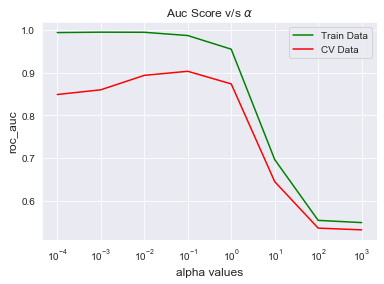

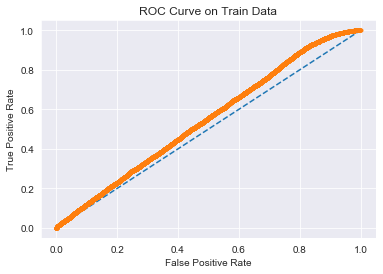

In [34]:
sgd_Classifier(BOW_X_train_sc,BOW_X_cv_sc,y_tr,y_cv)

AUC Score 0.9014123135858976


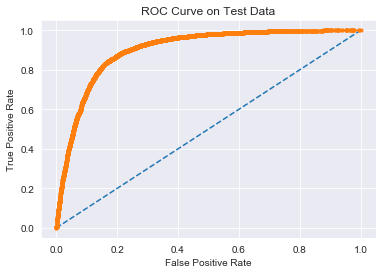

the maximum value of tpr*(1-fpr) 0.6992163092965065 for threshold 0.83
macro f1 score for data : 0.7616702373380286
micro f1 scoore for data: 0.839814674160717
hamming loss for data: 0.160185325839283
Precision recall report for data:
               precision    recall  f1-score   support

           0       0.50      0.83      0.63      4234
           1       0.96      0.84      0.90     22098

    accuracy                           0.84     26332
   macro avg       0.73      0.84      0.76     26332
weighted avg       0.89      0.84      0.85     26332



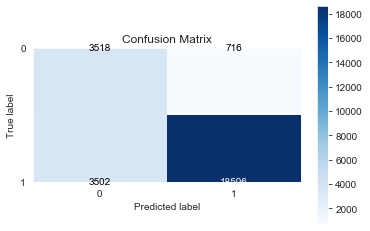

In [42]:
testing(BOW_X_train_sc,y_tr,BOW_X_test_sc,y_test,optimal_alpha = 0.1)

## Top 10 Features:

In [43]:
clf = SGDClassifier(alpha=0.1, penalty='l2', loss='hinge', random_state=1)
clf.fit(BOW_X_train_sc,y_tr)
imp_feature(count_vec,clf)

			Negative						Positive
________________________________________________________________________________________________
	-0.1200	disappoint     				0.2106	great          
	-0.0827	worst          				0.1925	love           
	-0.0761	aw             				0.1549	good           
	-0.0752	terribl        				0.1403	best           
	-0.0746	horribl        				0.1202	delici         
	-0.0685	return         				0.0944	favorit        
	-0.0658	unfortun       				0.0910	excel          
	-0.0637	bad            				0.0907	perfect        
	-0.0587	threw          				0.0856	nice           
	-0.0571	wast           				0.0812	tasti          


### 2. TF-IDF

In [44]:
tf_idf_vec = TfidfVectorizer(ngram_range=(1,2))
tfidf_train = tf_idf_vec.fit_transform(X_tr)
tfidf_cv = tf_idf_vec.transform(X_cv)
tfidf_test = tf_idf_vec.transform(X_test)

print("The type of count vectorizer ",type(tfidf_train))
print("The shape of out text TFIDF vectorizer ",tfidf_train.get_shape())
print("Size of CV dataset:", tfidf_cv.shape)
print("Size of test dataset:", tfidf_test.shape)

The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of out text TFIDF vectorizer  (43008, 683623)
Size of CV dataset: (18433, 683623)
Size of test dataset: (26332, 683623)


In [45]:
#Standardizing data using StandardScaler

sc = StandardScaler(with_mean=False)
tfidf_train_sc = sc.fit_transform(tfidf_train)
tfidf_cv_sc = sc.transform(tfidf_cv)
tfidf_test_sc = sc.transform(tfidf_test)

0.0001  for train data, auc score is:   0.9999512634982233  and for CV data, auc score is:  0.8056273799165158
0.001  for train data, auc score is:   0.9999413586569227  and for CV data, auc score is:  0.8035302458158277
0.01  for train data, auc score is:   0.9999707954008202  and for CV data, auc score is:  0.8035615845678963
0.1  for train data, auc score is:   0.9999997718235677  and for CV data, auc score is:  0.8289205479634455
1  for train data, auc score is:   0.99999866070355  and for CV data, auc score is:  0.852079206845312
10  for train data, auc score is:   0.9999814065969894  and for CV data, auc score is:  0.8825466496267952
100  for train data, auc score is:   0.9964732197456504  and for CV data, auc score is:  0.7051166436673952
1000  for train data, auc score is:   0.9949876840282609  and for CV data, auc score is:  0.6808224094458983

 Best C Value 10 with highest roc_auc Score is 0.8825466496267952


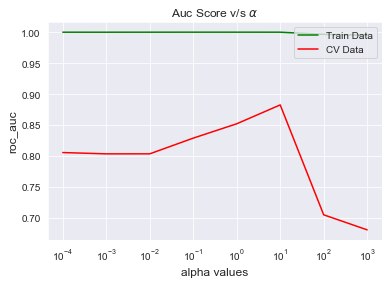

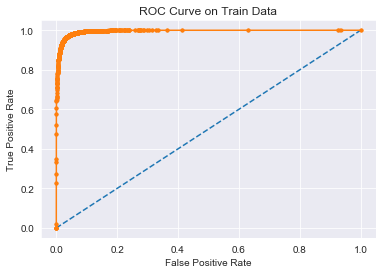

In [46]:
sgd_Classifier(tfidf_train_sc,tfidf_cv_sc,y_tr,y_cv)

AUC Score 0.8786545295523659


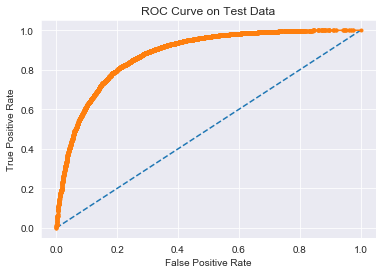

the maximum value of tpr*(1-fpr) 0.6421457591773632 for threshold 0.905
macro f1 score for data : 0.7216625318562069
micro f1 scoore for data: 0.8060154944554154
hamming loss for data: 0.19398450554458455
Precision recall report for data:
               precision    recall  f1-score   support

           0       0.44      0.79      0.57      4234
           1       0.95      0.81      0.87     22098

    accuracy                           0.81     26332
   macro avg       0.70      0.80      0.72     26332
weighted avg       0.87      0.81      0.83     26332



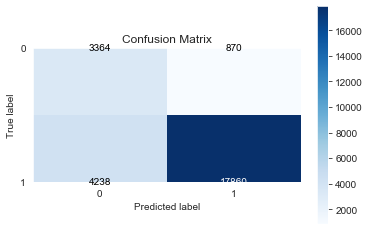

In [47]:
testing(tfidf_train_sc,y_tr,tfidf_test_sc,y_test,optimal_alpha = 10)

### Top 10 Features:

In [48]:
clf = SGDClassifier(alpha=10, penalty='l2', loss='hinge', random_state=1)
clf.fit(tfidf_train_sc,y_tr)
imp_feature(tf_idf_vec,clf)

			Negative						Positive
________________________________________________________________________________________________
	-0.0049	wast money     				0.0188	love           
	-0.0048	disappoint     				0.0179	great          
	-0.0047	worst          				0.0149	good           
	-0.0044	horribl        				0.0120	best           
	-0.0043	return         				0.0098	delici         
	-0.0040	aw             				0.0093	flavor         
	-0.0040	threw          				0.0089	favorit        
	-0.0040	wast           				0.0088	price          
	-0.0040	terribl        				0.0087	like           
	-0.0034	disgust        				0.0086	use            


### 3. Avg-W2V

In [49]:
i=0
list_sent_train=[]
for sent in X_tr:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_sent_train.append(filtered_sentence)

In [50]:
i=0
list_sent_train1=[]
for sent in X_tr:
    filtered_sentence=[]
    sent=sent
    for w in sent.split():
        for cleaned_words in w.split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_sent_train1.append(filtered_sentence)

In [51]:
i=0
list_sent_CV=[]
for sent in X_cv:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_sent_CV.append(filtered_sentence)

In [52]:
i=0
list_sent_test=[]
for sent in X_test:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_sent_test.append(filtered_sentence)

In [53]:
import gensim
w2v_model = gensim.models.Word2Vec(list_sent_train,min_count=5,size=50,workers=4)
w2v_words = list(w2v_model.wv.vocab)

In [54]:
def avg_w2v(list_of_sent):
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in list_of_sent: # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)        
    print(len(sent_vectors))
    print(len(sent_vectors[0]))
    return sent_vectors

In [55]:
train_avgw2v = avg_w2v(list_sent_train)

43008
50


In [56]:
cv_avgw2v = avg_w2v(list_sent_CV)

18433
50


In [57]:
test_avgw2v = avg_w2v(list_sent_test)

26332
50


In [58]:
#Standardizing data using StandardScaler

sc = StandardScaler(with_mean=False)
aw2v_X_train_sc = sc.fit_transform(train_avgw2v)
aw2v_X_cv_sc = sc.transform(cv_avgw2v)
aw2v_X_test_sc = sc.transform(test_avgw2v)

0.0001  for train data, auc score is:   0.8886771770948323  and for CV data, auc score is:  0.8929930098157965
0.001  for train data, auc score is:   0.8933152698287502  and for CV data, auc score is:  0.8981238708960798
0.01  for train data, auc score is:   0.8935538868208388  and for CV data, auc score is:  0.898586396712773
0.1  for train data, auc score is:   0.8914869377127547  and for CV data, auc score is:  0.8956439485023056
1  for train data, auc score is:   0.8694933923676691  and for CV data, auc score is:  0.8718704062229344
10  for train data, auc score is:   0.7229737734405649  and for CV data, auc score is:  0.7169716052072348
100  for train data, auc score is:   0.6579604189684378  and for CV data, auc score is:  0.6530919938445523
1000  for train data, auc score is:   0.6579605856364404  and for CV data, auc score is:  0.6530919938445523

 Best C Value 0.01 with highest roc_auc Score is 0.898586396712773


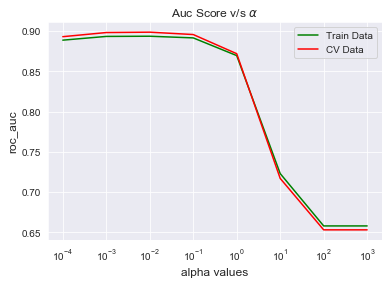

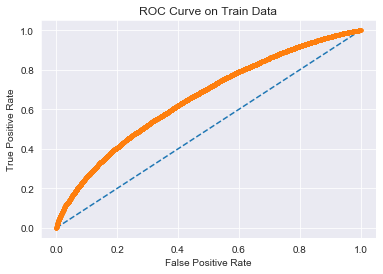

In [59]:
sgd_Classifier(aw2v_X_train_sc,aw2v_X_cv_sc,y_tr,y_cv)

AUC Score 0.8960868284888721


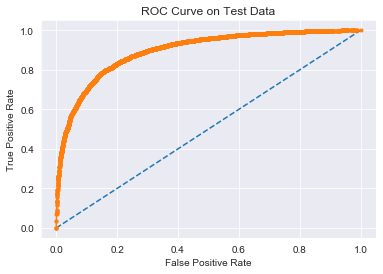

the maximum value of tpr*(1-fpr) 0.6687244474125715 for threshold 0.843
macro f1 score for data : 0.723479409787988
micro f1 scoore for data: 0.8011544888348777
hamming loss for data: 0.19884551116512228
Precision recall report for data:
               precision    recall  f1-score   support

           0       0.44      0.84      0.58      4234
           1       0.96      0.79      0.87     22098

    accuracy                           0.80     26332
   macro avg       0.70      0.82      0.72     26332
weighted avg       0.88      0.80      0.82     26332



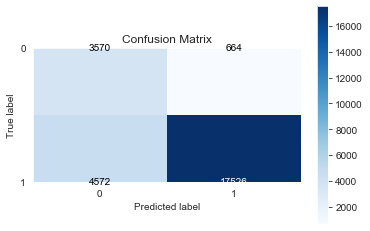

In [60]:
testing(aw2v_X_train_sc,y_tr,aw2v_X_test_sc,y_test,optimal_alpha = 0.01)

### 4. TF_IDF-W2V

In [62]:
tf_idf_vect = TfidfVectorizer()
tfidf_train = tf_idf_vect.fit_transform(X_tr)
print("The type of count vectorizer ",type(tfidf_train))
print("The shape of out text TFIDF vectorizer ",tfidf_train.get_shape())
tfidf_cv = tf_idf_vect.transform(X_cv)
tfidf_test = tf_idf_vect.transform(X_test)
print("CV Data Size: ",tfidf_cv.shape)
print("Test Data Size: ",tfidf_test.shape)

The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of out text TFIDF vectorizer  (43008, 24467)
CV Data Size:  (18433, 24467)
Test Data Size:  (26332, 24467)


In [63]:
t = tf_idf_vect.get_feature_names()
tfidf_sent_vectors_train = [] # the tfidf-w2v for each sentence/review is stored in this list
row=0
for sent in tqdm(list_sent_train):
    sent_vec = np.zeros(50)
    cnt_words = 0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tfidf = tfidf_train[row,t.index(word)]
            sent_vec += (vec * tfidf)
            cnt_words += tfidf
    if cnt_words != 0:
        sent_vec /= cnt_words
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1
print(len(tfidf_sent_vectors_train))
print(len(tfidf_sent_vectors_train[0]))

100%|████████████████████████████████████████████████████████████████████████████| 43008/43008 [14:34<00:00, 49.21it/s]


43008
50


In [64]:
import time
start1 = time.clock()
t = tf_idf_vect.get_feature_names()
tfidf_sent_vectors_CV = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_sent_CV):
    sent_vec = np.zeros(50)
    cnt_words = 0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tfidf = tfidf_cv[row,t.index(word)]
            sent_vec += (vec * tfidf)
            cnt_words += tfidf
    if cnt_words != 0:
        sent_vec /= cnt_words
    tfidf_sent_vectors_CV.append(sent_vec)
    row += 1
print(len(tfidf_sent_vectors_CV))
print(len(tfidf_sent_vectors_CV[0]))
print((time.clock()-start1)/60)

100%|████████████████████████████████████████████████████████████████████████████| 18433/18433 [07:43<00:00, 39.78it/s]


18433
50
7.723742138833344


In [65]:
start2 = time.clock()
t = tf_idf_vect.get_feature_names()
tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_sent_test):
    sent_vec = np.zeros(50)
    cnt_words = 0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tfidf = tfidf_test[row,t.index(word)]
            sent_vec += (vec * tfidf)
            cnt_words += tfidf
    if cnt_words != 0:
        sent_vec /= cnt_words
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1
print(len(tfidf_sent_vectors_test))
print(len(tfidf_sent_vectors_test[0]))
print((time.clock()-start1)/60)

100%|████████████████████████████████████████████████████████████████████████████| 26332/26332 [10:16<00:00, 42.69it/s]


26332
50
18.00607352955


In [66]:
train_tfidfw2v = tfidf_sent_vectors_train
cv_tfidfw2v = tfidf_sent_vectors_CV
test_tfidfw2v = tfidf_sent_vectors_test

In [67]:
#Standardizing data using StandardScaler

sc = StandardScaler(with_mean=False)
tfidfw2v_X_train_sc = sc.fit_transform(train_tfidfw2v)
tfidfw2v_X_cv_sc = sc.transform(cv_tfidfw2v)
tfidfw2v_X_test_sc = sc.transform(test_tfidfw2v)

0.0001  for train data, auc score is:   0.8642888030292941  and for CV data, auc score is:  0.8672822683807803
0.001  for train data, auc score is:   0.8635906902904539  and for CV data, auc score is:  0.8652122463521124
0.01  for train data, auc score is:   0.8640050944059154  and for CV data, auc score is:  0.8659638070044453
0.1  for train data, auc score is:   0.8643959705550021  and for CV data, auc score is:  0.8666425286006081
1  for train data, auc score is:   0.8364282225595618  and for CV data, auc score is:  0.8387163279234457
10  for train data, auc score is:   0.6917664121752087  and for CV data, auc score is:  0.6856552348330295
100  for train data, auc score is:   0.636980675400652  and for CV data, auc score is:  0.6322705795299564
1000  for train data, auc score is:   0.6369807785760822  and for CV data, auc score is:  0.6322706014298531

 Best C Value 0.0001 with highest roc_auc Score is 0.8672822683807803


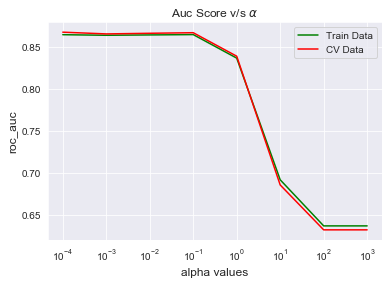

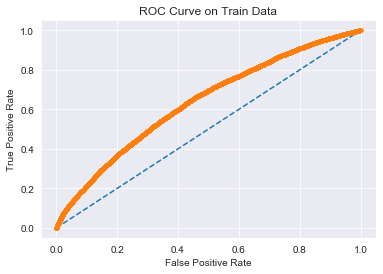

In [68]:
sgd_Classifier(tfidfw2v_X_train_sc,tfidfw2v_X_cv_sc,y_tr,y_cv)

AUC Score 0.865313530362644


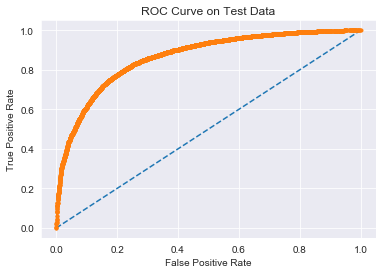

the maximum value of tpr*(1-fpr) 0.6204479568895939 for threshold 0.825
macro f1 score for data : 0.6978378219519505
micro f1 scoore for data: 0.7809129576181071
hamming loss for data: 0.21908704238189275
Precision recall report for data:
               precision    recall  f1-score   support

           0       0.41      0.80      0.54      4234
           1       0.95      0.78      0.86     22098

    accuracy                           0.78     26332
   macro avg       0.68      0.79      0.70     26332
weighted avg       0.86      0.78      0.81     26332



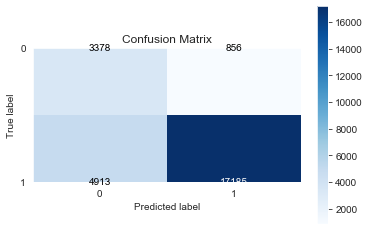

In [69]:
testing(tfidfw2v_X_train_sc,y_tr,tfidfw2v_X_test_sc,y_test,optimal_alpha = 0.0001)

In [70]:
final_sample = final.sample(20000)
final_sample.shape

(20000, 11)

In [72]:
X = final_sample['CleanedText']
y = final_sample['Score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_tr, X_cv, y_tr, y_cv = train_test_split(X_train, y_train, test_size=0.3, random_state=0)

print("Size of X_train and y_train:", X_train.shape,y_train.shape)
print("Size of X_test and y_test:", X_test.shape,y_test.shape)
print("Size of X_tr and y_tr:", X_tr.shape,y_tr.shape)
print("Size of X_cv and y_cv:", X_cv.shape,y_cv.shape)

Size of X_train and y_train: (14000,) (14000,)
Size of X_test and y_test: (6000,) (6000,)
Size of X_tr and y_tr: (9800,) (9800,)
Size of X_cv and y_cv: (4200,) (4200,)


## SVM for RBF Kernel:

In [83]:
def SVM(X_train,X_cv,y_train,y_cv):
    pred_cv = []
    pred_train = []
    C = [10 ** x for x in range(-4, 4)]
    gamma = [10** x for x in range(-4,2)]
    for i in C:
        for j in tqdm(gamma):
            clf = SVC(kernel='rbf',probability=True,C=i,gamma=j)
            clf.fit(X_train,y_train)
            prob_train = clf.predict_proba(X_train)[:,1]
            prob_cv = clf.predict_proba(X_cv)[:,1]
            auc_score_train = roc_auc_score(y_train,prob_train)
            auc_score_cv = roc_auc_score(y_cv,prob_cv)
            pred_train.append(auc_score_train)
            pred_cv.append(auc_score_cv)
            
    cmap=sns.light_palette("green")
    # representing heat map for auc score
    print("-"*30, "AUC Score for training data", "-"*30)
    pred_train = np.array(pred_train)
    pred_train = pred_train.reshape(len(C),len(gamma))
    plt.figure(figsize=(10,5))
    sns.heatmap(pred_train,annot=True, cmap=cmap, fmt=".3f", xticklabels=gamma,yticklabels=C)
    plt.xlabel('gamma')
    plt.ylabel('C')
    plt.show()
    print("-"*30, "AUC Score for CV data", "-"*30)
    pred_cv = np.array(pred_cv)
    pred_cv = pred_cv.reshape(len(C),len(gamma))
    plt.figure(figsize=(10,5))
    sns.heatmap(pred_cv, annot=True, cmap=cmap, fmt=".3f", xticklabels=gamma, yticklabels=C)
    plt.xlabel('gamma')
    plt.ylabel('C')
    plt.show()

## Model Testing

In [91]:
import scikitplot.metrics as skplt
def testing_SVM(X_train,y_train,X_test,y_test,optimal_C,optimal_gamma):
    clf = SVC(C=optimal_C,kernel='rbf',probability=True,gamma=optimal_gamma)
    clf.fit(X_train,y_train)
    prob_test = clf.predict_proba(X_test)[:,1] 
    print("AUC Score",roc_auc_score(y_test,prob_test))
    # plot roc curve
    fpr, tpr, thresholds = roc_curve(y_test,prob_test)
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    plt.title("Line Plot of ROC Curve on Test Data")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')    
    plt.show()
    
    def find_best_threshold(threshold, fpr, tpr):
        t = threshold[np.argmax(tpr*(1-fpr))]
        print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
        return t
    def predict_with_best_t(proba, threshold):
        predictions = []
        for i in proba:
            if i>=threshold:
                predictions.append(1)
            else:
                predictions.append(0)
        return predictions

    best_t = find_best_threshold(thresholds, fpr, tpr)
    predicted = predict_with_best_t(prob_test, best_t)
    skplt.plot_confusion_matrix(y_test,predicted)

    print("macro f1 score for data :",f1_score(y_test, predicted, average = 'macro'))
    print("micro f1 scoore for data:",f1_score(y_test, predicted, average = 'micro'))
    print("hamming loss for data:",hamming_loss(y_test,predicted))
    print("Precision recall report for data:\n",classification_report(y_test, predicted))

### 1. Bag of Words(BOW)

In [75]:
count_vec = CountVectorizer()
BOW_X_train = count_vec.fit_transform(X_tr)
BOW_X_cv = count_vec.transform(X_cv)
BOW_X_test = count_vec.transform(X_test)

In [76]:
sc = StandardScaler(with_mean=False)
BOW_X_train_sc = sc.fit_transform(BOW_X_train)
BOW_X_cv_sc = sc.transform(BOW_X_cv)
BOW_X_test_sc = sc.transform(BOW_X_test)



  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

 17%|█████████████▊                                                                     | 1/6 [01:44<08:42, 104.60s/it]

 33%|███████████████████████████▋                                                       | 2/6 [03:30<06:59, 104.90s/it]

 50%|█████████████████████████████████████████▌                                         | 3/6 [05:10<05:10, 103.44s/it]

 67%|███████████████████████████████████████████████████████▎                           | 4/6 [06:52<03:26, 103.06s/it]

 83%|█████████████████████████████████████████████████████████████████████▏             | 5/6 [08:36<01:43, 103.30s/it]

100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [10:31<00:00, 106.91s/it]

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

 17%|█████████████▊           

------------------------------ AUC Score for training data ------------------------------


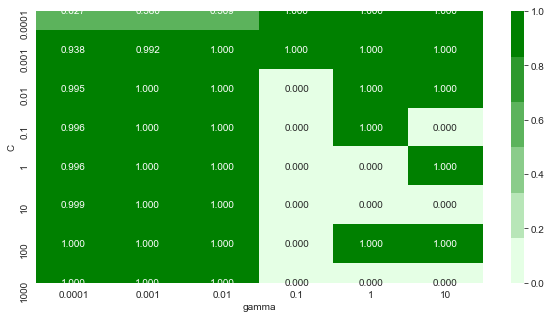

------------------------------ AUC Score for CV data ------------------------------


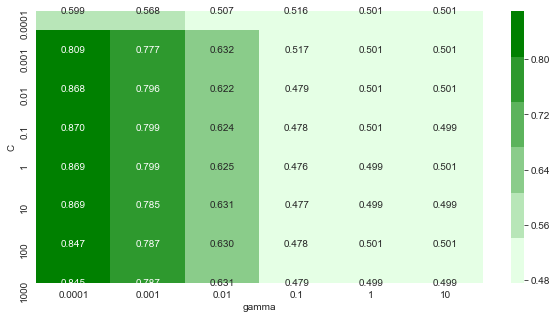

In [85]:
SVM(BOW_X_train_sc,BOW_X_cv_sc,y_tr,y_cv)

AUC Score 0.7727964827687586


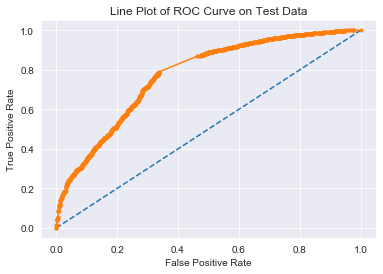

the maximum value of tpr*(1-fpr) 0.5224915287042665 for threshold 0.791
macro f1 score for data : 0.6633649412476893
micro f1 scoore for data: 0.7695
hamming loss for data: 0.2305
Precision recall report for data:
               precision    recall  f1-score   support

           0       0.37      0.66      0.47       943
           1       0.93      0.79      0.85      5057

    accuracy                           0.77      6000
   macro avg       0.65      0.73      0.66      6000
weighted avg       0.84      0.77      0.79      6000



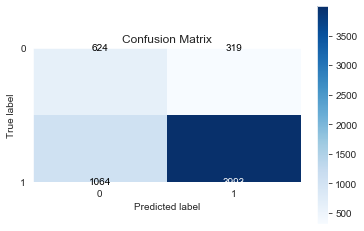

In [92]:
testing_SVM(BOW_X_train_sc,y_tr,BOW_X_test_sc,y_test,0.001,0.001)

## 2. TF-IDF

In [94]:
tf_idf_vec = TfidfVectorizer(ngram_range=(1,2))
tfidf_train = tf_idf_vec.fit_transform(X_tr)
tfidf_cv = tf_idf_vec.transform(X_cv)
tfidf_test = tf_idf_vec.transform(X_test)

print("The type of count vectorizer ",type(tfidf_train))
print("The shape of out text TFIDF vectorizer ",tfidf_train.get_shape())
print("Size of CV dataset:", tfidf_cv.shape)
print("Size of test dataset:", tfidf_test.shape)

The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of out text TFIDF vectorizer  (9800, 226644)
Size of CV dataset: (4200, 226644)
Size of test dataset: (6000, 226644)


In [95]:
#Standardizing data using StandardScaler

sc = StandardScaler(with_mean=False)
tfidf_train_sc = sc.fit_transform(tfidf_train)
tfidf_cv_sc = sc.transform(tfidf_cv)
tfidf_test_sc = sc.transform(tfidf_test)



  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

 17%|█████████████▊                                                                     | 1/6 [02:35<12:58, 155.78s/it]

 33%|███████████████████████████▋                                                       | 2/6 [04:45<09:52, 148.06s/it]

 50%|█████████████████████████████████████████▌                                         | 3/6 [07:13<07:24, 148.08s/it]

 67%|███████████████████████████████████████████████████████▎                           | 4/6 [09:48<05:00, 150.16s/it]

 83%|█████████████████████████████████████████████████████████████████████▏             | 5/6 [12:07<02:26, 146.80s/it]

100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [14:50<00:00, 151.54s/it]

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

 17%|█████████████▊           

------------------------------ AUC Score for training data ------------------------------


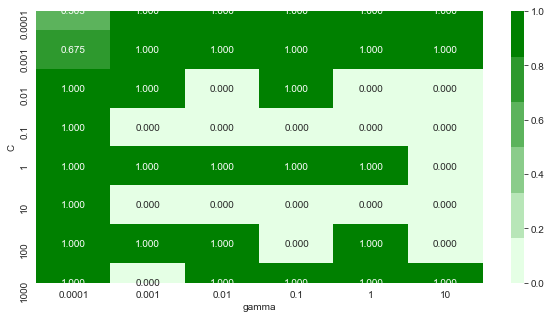

------------------------------ AUC Score for CV data ------------------------------


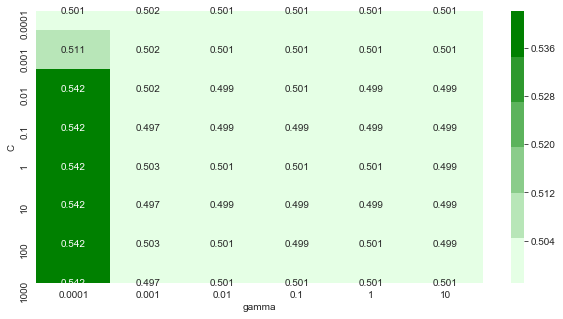

In [96]:
SVM(tfidf_train_sc,tfidf_cv_sc,y_tr,y_cv)

AUC Score 0.5440874350537489


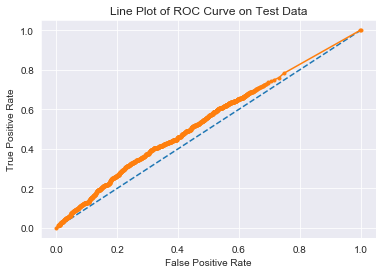

the maximum value of tpr*(1-fpr) 0.2842274633336905 for threshold 0.07
macro f1 score for data : 0.47423183549130205
micro f1 scoore for data: 0.5598333333333333
hamming loss for data: 0.44016666666666665
Precision recall report for data:
               precision    recall  f1-score   support

           0       0.18      0.50      0.26       943
           1       0.86      0.57      0.69      5057

    accuracy                           0.56      6000
   macro avg       0.52      0.53      0.47      6000
weighted avg       0.75      0.56      0.62      6000



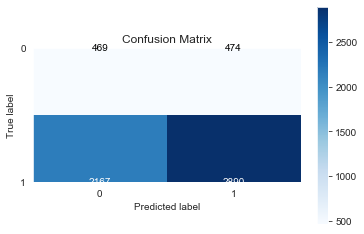

In [97]:
testing_SVM(tfidf_train_sc,y_tr,tfidf_test_sc,y_test,0.001,0.0001)

## 3. Avg W2V

In [98]:
i=0
list_sent_train=[]
for sent in X_tr:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_sent_train.append(filtered_sentence)

In [99]:
i=0
list_sent_CV=[]
for sent in X_cv:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_sent_CV.append(filtered_sentence)

In [100]:
i=0
list_sent_test=[]
for sent in X_test:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_sent_test.append(filtered_sentence)

In [101]:
w2v_model = gensim.models.Word2Vec(list_sent_train,min_count=5,size=50,workers=4)
w2v_words = list(w2v_model.wv.vocab)

In [102]:
train_avgw2v = avg_w2v(list_sent_train)

9800
50


In [103]:
cv_avgw2v = avg_w2v(list_sent_CV)

4200
50


In [104]:
test_avgw2v = avg_w2v(list_sent_test)

6000
50


In [105]:
sc = StandardScaler(with_mean=False)
aw2v_X_train_sc = sc.fit_transform(train_avgw2v)
aw2v_X_cv_sc = sc.transform(cv_avgw2v)
aw2v_X_test_sc = sc.transform(test_avgw2v)



  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

 17%|██████████████                                                                      | 1/6 [00:29<02:28, 29.67s/it]

 33%|████████████████████████████                                                        | 2/6 [00:55<01:53, 28.49s/it]

 50%|██████████████████████████████████████████                                          | 3/6 [01:22<01:24, 28.20s/it]

 67%|████████████████████████████████████████████████████████                            | 4/6 [01:50<00:56, 28.10s/it]

 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [02:15<00:27, 27.03s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:47<00:00, 28.49s/it]

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

 17%|██████████████           

------------------------------ AUC Score for training data ------------------------------


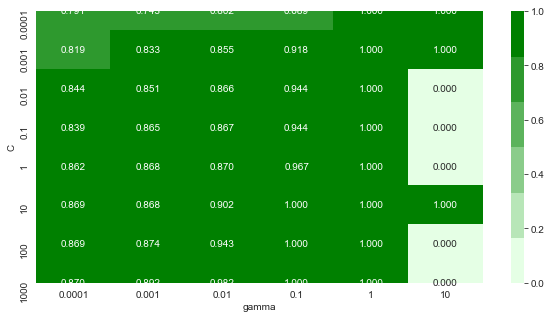

------------------------------ AUC Score for CV data ------------------------------


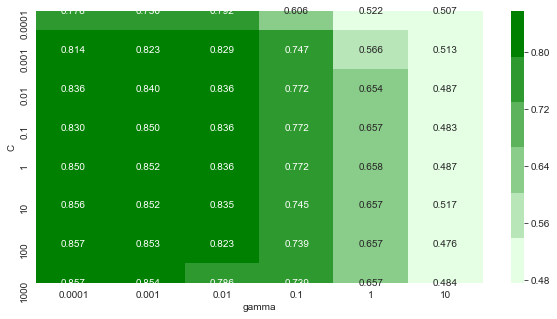

In [106]:
SVM(aw2v_X_train_sc,aw2v_X_cv_sc,y_tr,y_cv)

AUC Score 0.8202554505362096


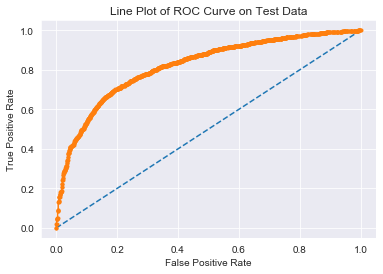

the maximum value of tpr*(1-fpr) 0.5653379679500985 for threshold 0.952
macro f1 score for data : 0.6394972980675924
micro f1 scoore for data: 0.7166666666666667
hamming loss for data: 0.2833333333333333
Precision recall report for data:
               precision    recall  f1-score   support

           0       0.33      0.81      0.47       943
           1       0.95      0.70      0.81      5057

    accuracy                           0.72      6000
   macro avg       0.64      0.75      0.64      6000
weighted avg       0.85      0.72      0.75      6000



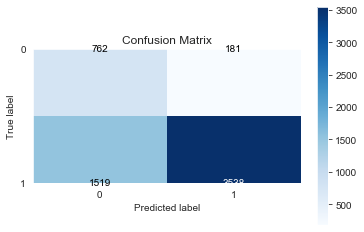

In [107]:
testing_SVM(aw2v_X_train_sc,y_tr,aw2v_X_test_sc,y_test,0.001,0.001)

## 4. TD-IDF W2V 

In [108]:
tf_idf_vect = TfidfVectorizer()
tfidf_train = tf_idf_vect.fit_transform(X_tr)
print("The type of count vectorizer ",type(tfidf_train))
print("The shape of out text TFIDF vectorizer ",tfidf_train.get_shape())
tfidf_cv = tf_idf_vect.transform(X_cv)
tfidf_test = tf_idf_vect.transform(X_test)
print("CV Data Size: ",tfidf_cv.shape)
print("Test Data Size: ",tfidf_test.shape)

The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of out text TFIDF vectorizer  (9800, 12498)
CV Data Size:  (4200, 12498)
Test Data Size:  (6000, 12498)


In [109]:
t = tf_idf_vect.get_feature_names()
tfidf_sent_vectors_train = [] # the tfidf-w2v for each sentence/review is stored in this list
row=0
for sent in tqdm(list_sent_train):
    sent_vec = np.zeros(50)
    cnt_words = 0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tfidf = tfidf_train[row,t.index(word)]
            sent_vec += (vec * tfidf)
            cnt_words += tfidf
    if cnt_words != 0:
        sent_vec /= cnt_words
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1
print(len(tfidf_sent_vectors_train))
print(len(tfidf_sent_vectors_train[0]))



  0%|                                                                                         | 0/9800 [00:00<?, ?it/s]

  0%|                                                                                 | 3/9800 [00:00<06:48, 23.96it/s]

  0%|                                                                                | 12/9800 [00:00<05:27, 29.87it/s]

  0%|▏                                                                               | 19/9800 [00:00<04:31, 35.97it/s]

  0%|▏                                                                               | 24/9800 [00:00<04:30, 36.16it/s]

  0%|▎                                                                               | 31/9800 [00:00<03:52, 41.94it/s]

  0%|▎                                                                               | 38/9800 [00:00<03:25, 47.41it/s]

  0%|▍                                                                               | 46/9800 [00:00<03:01, 53.63it/s]

  1%|▍                        

9800
50


In [110]:
import time
start1 = time.clock()
t = tf_idf_vect.get_feature_names()
tfidf_sent_vectors_CV = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_sent_CV):
    sent_vec = np.zeros(50)
    cnt_words = 0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tfidf = tfidf_cv[row,t.index(word)]
            sent_vec += (vec * tfidf)
            cnt_words += tfidf
    if cnt_words != 0:
        sent_vec /= cnt_words
    tfidf_sent_vectors_CV.append(sent_vec)
    row += 1
print(len(tfidf_sent_vectors_CV))
print(len(tfidf_sent_vectors_CV[0]))
print((time.clock()-start1)/60)




  0%|                                                                                         | 0/4200 [00:00<?, ?it/s]

  0%|▏                                                                                | 7/4200 [00:00<01:07, 62.05it/s]

  0%|▎                                                                               | 16/4200 [00:00<01:01, 68.41it/s]

  0%|▍                                                                               | 21/4200 [00:00<01:09, 60.42it/s]

  1%|▌                                                                               | 29/4200 [00:00<01:09, 60.28it/s]

  1%|▋                                                                               | 37/4200 [00:00<01:04, 64.97it/s]

  1%|▊                                                                               | 43/4200 [00:00<01:13, 56.43it/s]

  1%|▉                                                                               | 49/4200 [00:00<01:17, 53.85it/s]

  1%|█                        

4200
50
1.1894894941001743


In [111]:
start2 = time.clock()
t = tf_idf_vect.get_feature_names()
tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_sent_test):
    sent_vec = np.zeros(50)
    cnt_words = 0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tfidf = tfidf_test[row,t.index(word)]
            sent_vec += (vec * tfidf)
            cnt_words += tfidf
    if cnt_words != 0:
        sent_vec /= cnt_words
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1
print(len(tfidf_sent_vectors_test))
print(len(tfidf_sent_vectors_test[0]))
print((time.clock()-start1)/60)



  0%|                                                                                         | 0/6000 [00:00<?, ?it/s]

  0%|▏                                                                               | 10/6000 [00:00<01:23, 71.71it/s]

  0%|▏                                                                               | 16/6000 [00:00<01:34, 63.59it/s]

  0%|▎                                                                               | 24/6000 [00:00<01:29, 66.99it/s]

  0%|▍                                                                               | 29/6000 [00:00<01:42, 58.27it/s]

  1%|▍                                                                               | 34/6000 [00:00<01:59, 49.90it/s]

  1%|▌                                                                               | 40/6000 [00:00<02:02, 48.74it/s]

  1%|▋                                                                               | 48/6000 [00:00<01:47, 55.14it/s]

  1%|▋                        

6000
50
2.9036143833004946


In [112]:
train_tfidfw2v = tfidf_sent_vectors_train
cv_tfidfw2v = tfidf_sent_vectors_CV
test_tfidfw2v = tfidf_sent_vectors_test

In [113]:
sc = StandardScaler(with_mean=False)
tfidfw2v_X_train_sc = sc.fit_transform(train_tfidfw2v)
tfidfw2v_X_cv_sc = sc.transform(cv_tfidfw2v)
tfidfw2v_X_test_sc = sc.transform(test_tfidfw2v)



  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

 17%|██████████████                                                                      | 1/6 [00:39<03:15, 39.16s/it]

 33%|████████████████████████████                                                        | 2/6 [01:18<02:36, 39.17s/it]

 50%|██████████████████████████████████████████                                          | 3/6 [01:57<01:57, 39.12s/it]

 67%|████████████████████████████████████████████████████████                            | 4/6 [02:37<01:18, 39.38s/it]

 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [03:16<00:39, 39.32s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [04:08<00:00, 43.11s/it]

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

 17%|██████████████           

------------------------------ AUC Score for training data ------------------------------


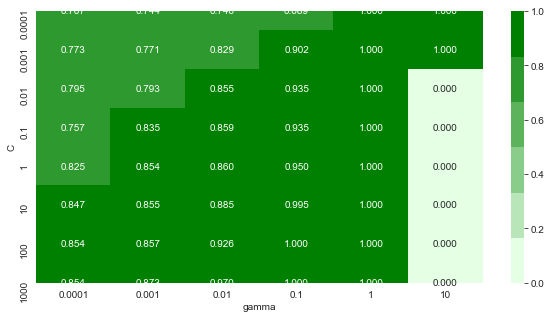

------------------------------ AUC Score for CV data ------------------------------


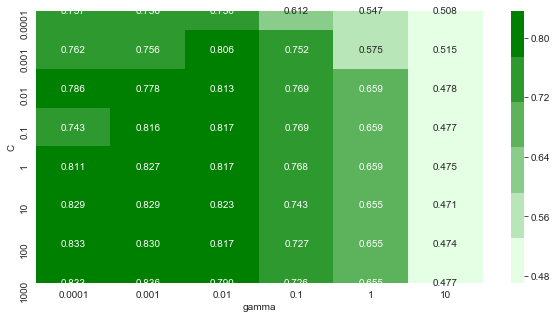

In [114]:
SVM(tfidfw2v_X_train_sc,tfidfw2v_X_cv_sc,y_tr,y_cv)

AUC Score 0.8038964500348205


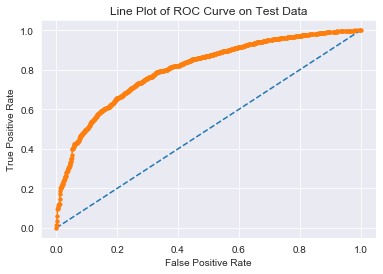

the maximum value of tpr*(1-fpr) 0.5356987605349912 for threshold 0.896
macro f1 score for data : 0.6399268464302035
micro f1 scoore for data: 0.7291666666666665
hamming loss for data: 0.2708333333333333
Precision recall report for data:
               precision    recall  f1-score   support

           0       0.34      0.74      0.46       943
           1       0.94      0.73      0.82      5057

    accuracy                           0.73      6000
   macro avg       0.64      0.73      0.64      6000
weighted avg       0.84      0.73      0.76      6000



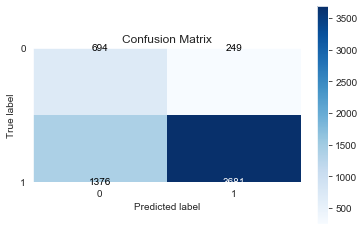

In [116]:
testing_SVM(tfidfw2v_X_train_sc,y_tr,tfidfw2v_X_test_sc,y_test,0.001,0.01)

In [117]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Best Hyper Parameter(C)","Test Auc Score"]
x.add_row(["BoW","Liner kernel",0.1,90.14])
x.add_row(["Tf-Idf","Liner kernel",10,87.86])
x.add_row(["Avg-W2V","Liner kernel",0.01,89.60])
x.add_row(["TfIdf-W2V","Liner kernel",0.0001,86.53])

y = PrettyTable()
y.field_names = ["Vectorizer", "Model", "Best Hyper Parameter(C & gamma)","Test Auc Score"]
y.add_row(["BoW","RBF kernel",(0.001,0.001),72.27])
y.add_row(["Tf-Idf","RBF kernel",(0.001,0.0001),54.40])
y.add_row(["Avg-W2V","RBF kernel",(0.001,0.001),82.02])
y.add_row(["TfIdf-W2V","RBF kernel",(0.001,0.01),80.28])
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
printmd('****Final Conclusion:****')
print(x)
print(y)

****Final Conclusion:****

+------------+--------------+-------------------------+----------------+
| Vectorizer |    Model     | Best Hyper Parameter(C) | Test Auc Score |
+------------+--------------+-------------------------+----------------+
|    BoW     | Liner kernel |           0.1           |     90.14      |
|   Tf-Idf   | Liner kernel |            10           |     87.86      |
|  Avg-W2V   | Liner kernel |           0.01          |      89.6      |
| TfIdf-W2V  | Liner kernel |          0.0001         |     86.53      |
+------------+--------------+-------------------------+----------------+
+------------+------------+---------------------------------+----------------+
| Vectorizer |   Model    | Best Hyper Parameter(C & gamma) | Test Auc Score |
+------------+------------+---------------------------------+----------------+
|    BoW     | RBF kernel |          (0.001, 0.001)         |     72.27      |
|   Tf-Idf   | RBF kernel |         (0.001, 0.0001)         |      54.4      |
|  Avg-W2V   | RBF ke